In [1]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, f1_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
import shap
from skopt import BayesSearchCV
import skopt.space as space
import skopt.plots as plots
import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from ff_custom_scripts import *
# import RandomForestRegressor and selectfrom model
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
# import knn imputer
from sklearn.impute import KNNImputer
# from sklearn import SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score


In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='remove')
alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

meta = pd.read_csv('../metadata/metadata.csv', index_col=0)

train

(1172, 10396) (294, 10396) (530, 10396) (803, 10396)


,cf1lenhr,cf1lenmin,cf1fint,cf1citsm,f1citywt,f1a2,f1a3,f1a4,f1a4a,f1a5,...,cf5povca,cf5povcab,cm5samp,cf5samp,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,,,,,,,,,,,,,,,,
3534,0.0,35.0,1,1,13.621670,1,1,1,NaN,1,...,4,4,NaN,NaN,3.50,3.75,0.090909,0.0,1.0,0.0
2273,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7,3.00,3.50,0.000000,0.0,0.0,1.0
69,1.0,0.0,1,1,161.652405,1,1,1,NaN,1,...,4,3,NaN,NaN,3.00,2.75,0.181818,0.0,0.0,1.0
1593,0.0,45.0,1,1,79.580742,1,1,1,NaN,1,...,5,5,NaN,NaN,3.00,3.75,0.000000,0.0,0.0,0.0
137,NaN,40.0,1,1,5.386045,1,1,1,NaN,1,...,NaN,NaN,NaN,7,2.25,3.25,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,0.0,30.0,1,1,22.704456,1,1,1,NaN,1,...,4,4,NaN,NaN,NaN,NaN,0.363636,0.0,NaN,1.0
1829,0.0,45.0,1,1,65.679031,1,1,1,NaN,1,...,1,1,NaN,NaN,NaN,3.75,0.000000,0.0,0.0,0.0
1821,0.0,38.0,1,1,44.814030,2,1,1,NaN,1,...,NaN,NaN,NaN,1,2.50,4.00,0.000000,0.0,1.0,0.0


In [3]:
meta

,varlab,type,one_topic,dtype,gpa,grit,materialHardship,eviction,layoff,jobTraining
new_name,,,,,,,,,,
cf1lenhr,What was the total length of interview - Hours,Continuous,paradata_and_weights,float64,0.000000,0.009892,0.003785,0.000000,0.007810,0.000000
cf1lenmin,What was the total length of interview - Minutes,Continuous,paradata_and_weights,float64,0.000000,0.000000,0.000000,0.001409,0.000000,0.000000
cf1fint,Constructed - Was father interviewed at baseline?,Binary,paradata_and_weights,object,0.021894,0.018859,0.016743,0.028699,0.000000,0.000000
cf1citsm,Constructed - Baseline city sample flag,Binary,paradata_and_weights,object,0.012485,0.023336,0.011364,0.000000,0.016590,0.004293
f1citywt,Father baseline city sample weight (20-cities ...,Continuous,paradata_and_weights,float64,0.000000,0.000000,0.000000,0.009234,0.002574,0.014284
...,...,...,...,...,...,...,...,...,...,...
cm5povca,Constructed - Mother's poverty category at 9-year,Ordered Categorical,finances,category,0.000000,0.000000,0.033440,0.031431,0.000000,0.015174
cf5povca,Constructed - Father's poverty category at 9-year,Ordered Categorical,finances,category,0.000000,0.030205,0.000000,0.000000,0.000000,0.001519
cf5povcab,Constructed - Father's poverty category at 9-y...,Ordered Categorical,finances,category,0.000000,0.000000,0.000000,0.016226,0.000454,0.000983


In [4]:
targets = ['gpa','grit','materialHardship','eviction','layoff','jobTraining']

predictors = {target: list(meta[meta[target] != 0].index) for target in targets}

# Model

In [3]:
def run_model(train, target='gpa', classifier=False):
    X_train, y_train = prepare_data(train, target)
    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    numerical_features = cols_per_type(X_train, 'Continuous')
    categorical_features = cols_per_type(X_train, 'Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    ordinal_features = cols_per_type(X_train, 'Ordinal')
    
    # import squential feature selector
    
    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        ('passthrough', ordinal_features),
        ('passthrough', binary_features)
    )
    
    search_space = {
            'regressor__n_estimators': space.Integer(600, 1500),
            'regressor__learning_rate': space.Real(0.01, 0.06),
            'regressor__max_depth': space.Integer(5, 10),
            'regressor__min_child_weight': space.Integer(3, 5),
            'regressor__gamma': space.Real(0.1, 0.25),
            # 'regressor__subsample': space.Real(0.5, 0.8),
            # 'regressor__colsample_bytree': space.Real(0.5, 0.8),
            # 'regressor__colsample_bylevel': space.Real(0.5, 0.8),
        }
    
    if classifier:
        score = 'neg_brier_score'
        xgboost = XGBClassifier(n_jobs=-1, eval_metric='logloss', objective='binary:logistic')
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
           
    else:
        xgboost = XGBRegressor(n_jobs=-1, eval_metric='rmse')
        score = 'neg_mean_squared_error'
    
    # feat_selector = Pipeline([
    #     # ('imputer', SimpleImputer(strategy='mean')),
    #     # knn imputer
    #     # ('imputer', KNNImputer(n_neighbors=5)),
    #     ('variance_threshold', VarianceThreshold()),
    #     # ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=50, random_state=42)))
    # ])
        
    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                           # ('feature_selection', feat_selector),
                            ('regressor', xgboost)])
                            
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=10,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=42
    )

    # X_cv = preprocessor.fit_transform(X_cv)

    # model.fit(X_train, y_train, regressor__eval_set=[(X_cv, y_cv)], regressor__verbose=True)
    
    model.fit(X_train, y_train)
    
    return model

In [4]:
def shap_show(model, alldata, target, n=5):
    X, y = prepare_data(alldata, target)
    model  = model.best_estimator_.fit(X, y)
    Xtransform = model.named_steps['preprocessor'].transform(X)
    exp = shap.TreeExplainer(model.named_steps['regressor'])
    transformer = model.named_steps['preprocessor']
    names = transformer.get_feature_names_out()
    featnames = [splitfeatname(name) for name in names]
    shap_values = exp.shap_values(Xtransform)
    # get top n features
    top_n_idx = np.argsort(np.abs(shap_values).mean(0))[-n:]
    top_n_feat = [featnames[i] for i in top_n_idx]
    # # get questions
    top_n_vars = [meta[meta.index.isin([feat])].varlab.values for feat in top_n_feat]
    # # reverse order
    top_n_vars = top_n_vars[::-1]
    shap.summary_plot(shap_values, Xtransform, max_display=n, feature_names=featnames)
    return dict(zip(map(tuple, top_n_vars), top_n_feat))


def score_model(model,target,test,leaderboard,holdout,classifier=False):
    score = model.best_score_ * -1
    print(f'Best CV score: {score}')
    
    meancvscore = model.cv_results_['mean_test_score'].mean() * -1
    print(f'Mean CV score: {meancvscore}')
    
    # Get scores
    X_test, y_test = prepare_data(test, target)

    if classifier:
        print(f'Training scores')
        # y_pred = model.predict_proba(X_test)[:,1]
        y_pred = model.predict(X_test)
        # print y test first 10 values
        print(y_test[:10])
        # print y pred first 10 values
        print(y_pred[:10])
        # print brier score
        brier = brier_score_loss(y_test, y_pred)
        print(f'Test Brier: {brier}')
        # print mse
        mse = mean_squared_error(y_test, y_pred)
        print(f'Test MSE: {mse}')
        # print f1 score
        f1 = f1_score(y_test, y_pred.round())
        print(f'Test F1: {f1}')
        # print leaderboard scores
        print(f'Leaderboard scores')
        X_leaderboard, y_leaderboard = prepare_data(leaderboard, target)
        y_pred = model.predict(X_leaderboard)
        brier = brier_score_loss(y_leaderboard, y_pred)
        print(f'Leaderboard Brier: {brier}')
        f1 = f1_score(y_leaderboard, y_pred.round())
        print(f'Leaderboard F1: {f1}')
        # print holdout scores
        print(f'Holdout scores')
        X_holdout, y_holdout = prepare_data(holdout, target)
        y_pred = model.predict(X_holdout)
        brier = brier_score_loss(y_holdout, y_pred)
        print(f'Holdout Brier: {brier}')
        
    else:
        mse = mean_squared_error(y_test, model.predict(X_test))
        print(f'Test MSE: {mse}')
        
        rsquared = r2_score(y_test, model.predict(X_test))
        print(f'Test R2: {rsquared}')

    # Leaderboard scores
    
    


# GPA

In [7]:
gpa_model = run_model(train,target='gpa', classifier=False)

/home/abitporu/Documents/fragile_famile/ff_applied_ml/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/abitporu/Documents/fragile_famile/ff_applied_ml/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:119: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/abitporu/Documents/fragile_famile/ff_applied_ml/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/abitporu/Documents/fragile_famile/ff_applied_ml/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:119: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)
/home/abitporu/Documents/fragile_famile/ff_applied_ml/.ven

In [11]:
# OrderedDict([('regressor__gamma', 0.17995534416071732),
#              ('regressor__learning_rate', 0.04942262677968311),
#              ('regressor__max_depth', 8),
#              ('regressor__n_estimators', 1001)])

# OrderedDict([('regressor__gamma', 0.18123959883573634),
#              ('regressor__learning_rate', 0.022031009297759252),
#              ('regressor__max_depth', 8),
#              ('regressor__min_child_weight', 5),
#              ('regressor__n_estimators', 866)])

########### now without cv set
# gpa_model = run_model(train,target='gpa', classifier=False)
# # OrderedDict([('regressor__gamma', 0.17995534416071732),
# #              ('regressor__learning_rate', 0.04942262677968311),
# #              ('regressor__max_depth', 8),
# #              ('regressor__n_estimators', 1001)])

# # OrderedDict([('regressor__gamma', 0.18123959883573634),
# #              ('regressor__learning_rate', 0.022031009297759252),
# #              ('regressor__max_depth', 8),
# #              ('regressor__min_child_weight', 5),
# #              ('regressor__n_estimators', 866)])

# gpa_model.best_params_

gpa_model.best_params_

OrderedDict([('regressor__gamma', 0.2218593982536045),
             ('regressor__learning_rate', 0.018593578069828035),
             ('regressor__max_depth', 8),
             ('regressor__min_child_weight', 5),
             ('regressor__n_estimators', 1071)])

In [12]:
# Best CV score: 0.37028402610187
# Mean CV score: 0.37393245351241616
# Test MSE: 0.48688038947208856
# # Test R2: 0.01398843094911495

# Best CV score: 0.37162473170620636
# Mean CV score: 0.37944137824288887
# Test MSE: 0.44177994000734233
# # Test R2: 0.07358701470756002

# Best CV score: 0.3667114416922345
# Mean CV score: 0.3774214054273374
# Test MSE: 0.42709382275608465
# Test R2: 0.1043838175792936

# target encoder
# Best CV score: 0.3849631418451928
# Mean CV score: 0.39222013667404393
# Test MSE: 0.431112072202952
# Test R2: 0.09595754438621873

# with rf selector
# # Best CV score: 0.39591488340285813
# Mean CV score: 0.4057750046358922
# Test MSE: 0.47381557742018166
# Test R2: 0.006408250341569555

score_model(gpa_model,test,'gpa')

Best CV score: 0.40455772295647224
Mean CV score: 0.41166035899815523
Test MSE: 0.03244864189549334
Test R2: 0.9319551648121693


In [14]:
# shap_show(gpa_model, alldata, target='gpa')

Degrees of freedom <= 0 for slice.
All-NaN slice encountered
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

# Material Hardship

In [ ]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

In [ ]:
# OrderedDict([('regressor__gamma', 0.17995534416071732),
#              ('regressor__learning_rate', 0.04942262677968311),
#              ('regressor__max_depth', 8),
#              ('regressor__n_estimators', 1001)])

# OrderedDict([('regressor__gamma', 0.18373883555532844),
#              ('regressor__learning_rate', 0.07183206941666036),
#              ('regressor__max_depth', 7),
#              ('regressor__min_child_weight', 5),
#              ('regressor__n_estimators', 1105)])

model_materialHardship.best_params_

OrderedDict([('regressor__colsample_bylevel', 0.6230311876559942),
             ('regressor__colsample_bytree', 0.7183177229531976),
             ('regressor__gamma', 0.2399301998271751),
             ('regressor__learning_rate', 0.025789979674352433),
             ('regressor__max_depth', 8),
             ('regressor__min_child_weight', 4),
             ('regressor__n_estimators', 916),
             ('regressor__subsample', 0.7218512702571263)])

In [ ]:
# old score before target encoder
# Best CV score: 0.0219762262302777
# Mean CV score: 0.022120507065464746
# Test MSE: 0.026002860162396044
# Test R2: 0.07472058739699039


# with target encoder
# Best CV score: 0.0196997508337971
# Mean CV score: 0.019894279335968983
# Test MSE: 0.02105309624417009
# Test R2: 0.16791701153207583

score_model(model_materialHardship, test, target='materialHardship')

Best CV score: 0.01951882030711511
Mean CV score: 0.01973244062436174
Test MSE: 0.020947517122818386
Test R2: 0.17208982249514126


In [13]:
shap_show(model_materialHardship, alldata, target='materialHardship')


NameError: name 'model_materialHardship' is not defined

# Grit


In [ ]:
model_grit = run_model(train,target='grit', classifier=False)

In [ ]:
model_grit.best_params_

OrderedDict([('regressor__colsample_bylevel', 0.8),
             ('regressor__colsample_bytree', 0.5),
             ('regressor__gamma', 0.1),
             ('regressor__learning_rate', 0.01),
             ('regressor__max_depth', 6),
             ('regressor__min_child_weight', 4),
             ('regressor__n_estimators', 727),
             ('regressor__subsample', 0.7747876008901959)])

In [ ]:
score_model(model_grit, test, target='grit')

Best CV score: 0.24523454693302207
Mean CV score: 0.25189544390404406
Test MSE: 0.23301170818629294
Test R2: -0.008573851234549457


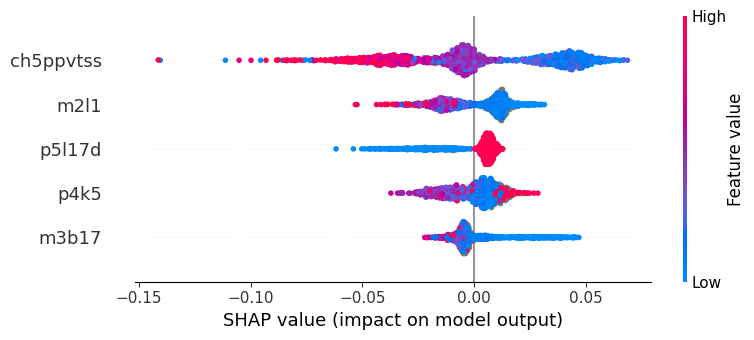

{('PPVT standard score',): 'm3b17',
 ('What was your total household income before taxes last year, all sources?',): 'p4k5',
 ("L17D. Discussed homework not done with child's teacher in this/last school year",): 'p5l17d',
 ('K5. Last month, how much money did you/household spend eating out?',): 'm2l1',
 ('How much do you pay out-of-pocket for all child care you currently use?',): 'ch5ppvtss'}

In [ ]:
shap_show(model_grit, alldata, target='grit')

In [ ]:
meta[meta.index=='m5a8f01']

,varlab,type,one_topic,dtype,gpa,grit,materialHardship,eviction,layoff,jobTraining
new_name,,,,,,,,,,
m5a8f01,A8F. Your relationship with the father at biol...,Ordered Categorical,romantic_relationships,category,0.0,0.008565,0.0,0.027009,0.015662,0.003894


# Eviction

In [ ]:
model_eviction = run_model(train,target='eviction', classifier=True)

In [ ]:
score_model(model_eviction, test, target='eviction',classifier=True)

Best CV score: 0.054580164096964624
Mean CV score: 0.0568184867798421
challengeID
1608    0.0
2235    0.0
70      0.0
1604    0.0
1605    0.0
203     0.0
831     0.0
1222    0.0
2610    0.0
2630    0.0
Name: eviction, dtype: float64
[0 0 0 0 0 0 0 0 0 0]
Test Brier: 0.0547945205479452
Test MSE: 0.0547945205479452
Test F1: 0.0


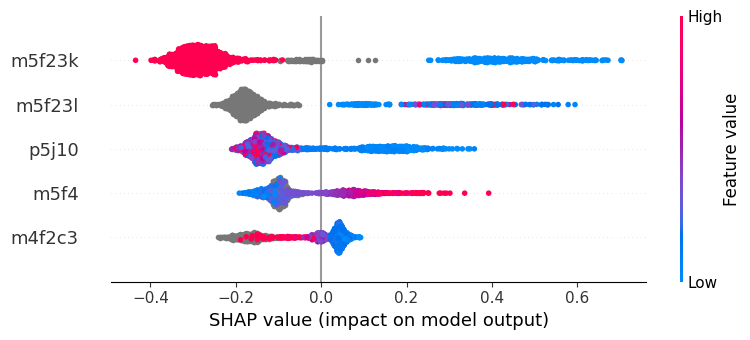

{("F23K. Telephone service disconnected because wasn't enough money in past 12 mont",): 'm4f2c3',
 ('F23L. Number of days in past 12 months you were without phone service',): 'm5f4',
 ('J10. Amount of money spent eating out in last month',): 'p5j10',
 ('F4. Amount of rent paid each month',): 'm5f23l',
 ("What is third person's age? (years)",): 'm5f23k'}

In [ ]:
# def shap_show(model, alldata, target, n=5):
#     X, y = prepare_data(alldata, target)
#     model  = model.best_estimator_.fit(X, y)
#     Xtransform = model.named_steps['preprocessor'].transform(X)
#     exp = shap.TreeExplainer(model.named_steps['regressor'])
#     transformer = model.named_steps['preprocessor']
#     names = transformer.get_feature_names_out()
#     featnames = [splitfeatname(name) for name in names]
#     shap_values = exp.shap_values(Xtransform)
#     # get top n features
#     top_n_idx = np.argsort(np.abs(shap_values).mean(0))[-n:]
#     top_n_feat = [featnames[i] for i in top_n_idx]
#     # # get questions
#     top_n_vars = [meta[meta.index.isin([feat])].varlab.values for feat in top_n_feat]
#     # # reverse order
#     top_n_vars = top_n_vars[::-1]
#     shap.summary_plot(shap_values, Xtransform, max_display=n, feature_names=featnames)
#     return dict(zip(top_n_vars, top_n_feat))

# shap_show(model_eviction, alldata, target='eviction')

shap_show(model_eviction, alldata, target='eviction')

In [ ]:
# top5 = ['m5f23k','p3m39','m5i3c']

# meta[meta.index.isin(top5)].varlab.values

# jobTraining

In [ ]:
model_job = run_model(train,target='jobTraining', classifier=True)

In [ ]:
score_model(model_job, test, target='jobTraining',classifier=True)

Best CV score: 0.18045114046529892
Mean CV score: 0.20337159559274443
challengeID
1608    0.0
2235    0.0
70      1.0
1604    0.0
1605    0.0
203     0.0
831     1.0
1222    0.0
2610    1.0
2630    0.0
Name: jobTraining, dtype: float64
[0 0 0 0 1 0 0 0 0 0]
Test Brier: 0.2089041095890411
Test MSE: 0.2089041095890411
Test F1: 0.22784810126582278


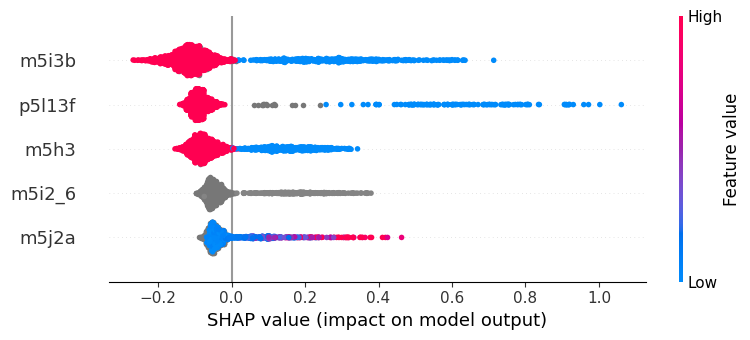

{('I3B. You have taken classes to improve job skills since last interview',): 'm5j2a',
 ('L13F. Gifted and talented program',): 'm5i2_6',
 ('H3. You had a religious experience that transformed your life since last intervi',): 'm5h3',
 ('I2_6. Attending program to improve reading',): 'p5l13f',
 ('J2A. Amount you gave/loaned money to friends/relatives during past 12 months',): 'm5i3b'}

In [ ]:
shap_show(model_job, alldata, target='jobTraining')

In [ ]:
top5 = ['m5i2_1','p5l13f','cm5hhinc']

meta[meta.index.isin(top5)].varlab.values

array(['I2_1. Attending regular high school',
       'L13F. Gifted and talented program',
       "Constructed - Mother's Household income (with imputed values)"],
      dtype=object)

# Layoff

In [5]:
model_layoff = run_model(train, target='layoff', classifier=True)

In [ ]:
# OrderedDict([('regressor__colsample_bylevel', 0.6230311876559942),
#              ('regressor__colsample_bytree', 0.7183177229531976),
#              ('regressor__gamma', 0.1932867998847834),
#              ('regressor__learning_rate', 0.03210597154409341),
#              ('regressor__max_depth', 8),
#              ('regressor__min_child_weight', 4),
#              ('regressor__n_estimators', 746),
#              ('regressor__scale_pos_weight', 13),
#              ('regressor__subsample', 0.5913389933109519)])
model_layoff.best_params_

OrderedDict([('regressor__colsample_bylevel', 0.5),
             ('regressor__colsample_bytree', 0.8),
             ('regressor__gamma', 0.25),
             ('regressor__learning_rate', 0.01),
             ('regressor__max_depth', 5),
             ('regressor__min_child_weight', 3),
             ('regressor__n_estimators', 600),
             ('regressor__scale_pos_weight', 2),
             ('regressor__subsample', 0.5)])

In [ ]:
score_model(model_layoff,'layoff',test,leaderboard,holdout, classifier=True)

Best CV score: 0.16974562093416284
Mean CV score: 0.18732822294784696
challengeID
1608    0.0
70      0.0
1604    0.0
1605    0.0
203     1.0
831     0.0
1222    0.0
2610    0.0
2630    1.0
2576    0.0
Name: layoff, dtype: float64
[0 0 0 0 0 0 0 0 0 0]
Test Brier: 0.20155038759689922
Test MSE: 0.20155038759689922
Test F1: 0.037037037037037035


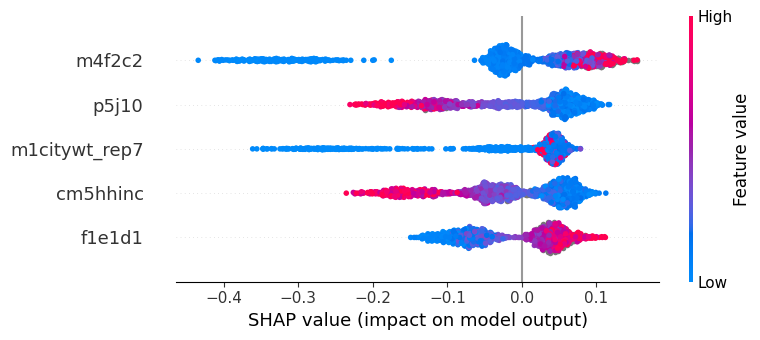

{("What is second person's age? (years)",): 'f1e1d1',
 ('J10. Amount of money spent eating out in last month',): 'cm5hhinc',
 ('Mother baseline city replicate weight no. 7',): 'm1citywt_rep7',
 ("Constructed - Mother's Household income (with imputed values)",): 'p5j10',
 ('People who currently live in your HH - 1st age?',): 'm4f2c2'}

In [ ]:
shap_show(model_layoff, alldata, target='layoff')